In [1]:
%matplotlib inline
import os
import scipy
import numpy as np
import pandas as pd
import pymc3 as pm
import theano.tensor as tt
from plotnine import *
import arviz as az
import geopandas
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import warnings
warnings.simplefilter('ignore', FutureWarning)
warnings.simplefilter('ignore', UserWarning)
import logging
logger = logging.getLogger('pymc3')
logger.setLevel(logging.ERROR)

# Data

In [2]:
# data
df = pd.read_csv('all_national_indicators.csv')
df.columns = df.columns.str.replace('.', '_')

# add 'un_region_name' and 'un_subregion_2' to Taiwan
df.loc[df.country_name_en =='Taiwan', 'un_region_name'] = 'Asia'
df.loc[df.country_name_en =='Taiwan', 'un_subregion_2'] = 'Eastern Asia'

# new variables
df['mean_aquaculture_production'] = df[['mean_aquaculture_production_freshwater','mean_aquaculture_production_marine','mean_aquaculture_production_brackish']].sum(axis=1)
df['unit_exports'] = df['mean_exports_USD1000'] / df['mean_exports_tonnes']
df['unit_imports'] = df['mean_imports_USD1000'] / df['mean_imports_tonnes']

# log transform highly skewed variables
df['sat_model_est_wealth'] = np.log(df['sat_model_est_wealth'] + 1)
df['eez_total'] = np.log(df['eez_total'] + 1)
df['inland_water_max'] = np.log(df['inland_water_max'] + 1)
df['mean_capture_production'] = np.log(df['mean_capture_production'] + 1)
df['mean_aquaculture_production'] = np.log(df['mean_aquaculture_production'] + 1)
df['unit_exports'] = np.log(df['unit_exports'] + 1)
df['unit_imports'] = np.log(df['unit_imports'] + 1)

# response variable
y = df['mean_total_production'] / df['direct_w_esitimated_ssf']

# scale by 100/IQR to use the same prior for intercepts across models
q = np.nanquantile(y, [0.25, 0.75])
scale_factor =  100/(q[1] - q[0])
y_scaled = y * scale_factor
y_scaled = y_scaled[~y_scaled.isnull()].copy()

# predictor variables of inetrest
cov = ['mean_educ', 'sat_model_est_wealth', 'gender_equality', 'language_diversity',
    'cultural_hegemony', 'working_percent_un', 'mean_voice_account']

cov_name = ['Education', 'Wealth', 'Gender equality', 'Language diversity',
    'Cultural hegemony', 'Working population', 'Voice and accountability']

x_cov = df[cov].copy()

# nuisance variables
nuisance = ['eez_total', 'inland_water_max', 'pp_eez_weighted']
x_nuisance = df[nuisance].copy()

# merge
X = x_cov.merge(x_nuisance, left_index=True, right_index=True)

# add population (log) to help impute missing predictors
X['log_pop'] = np.log(df['mean_population']+ 1)

# standardize all predictors
def standardize(x):
    return (x-np.mean(x))/np.std(x)

X = X.apply(standardize, axis=0)
 
# remove predictors without a response variable
X = X.loc[y_scaled.index, :].copy()

In [3]:
X.head()

,mean_educ,sat_model_est_wealth,gender_equality,language_diversity,cultural_hegemony,working_percent_un,mean_voice_account,eez_total,inland_water_max,pp_eez_weighted,log_pop
0,0.260914,2.616886,NaN,0.867746,1.133014,3.120179,-0.968561,-0.508430,-1.708048,0.530050,0.185005
2,-0.115912,0.237768,0.033855,0.196442,-1.061998,0.760866,0.170950,-1.243826,-0.557598,-0.540093,-0.284405
4,-1.145520,-0.960004,0.544356,1.002665,-1.061998,-1.873915,-1.075135,0.462677,0.702985,1.073305,0.679610
5,0.229784,0.323087,1.812350,-0.915817,-0.870753,0.084372,0.427769,0.819084,1.703263,0.744490,0.920739
7,0.970511,0.559565,0.630095,-0.557130,-0.736181,0.404521,1.450865,1.774756,1.675967,-0.642810,0.641634


In [4]:
y_scaled.head()

0     41.387568
2     18.496222
4     74.939824
5    417.933262
7     31.970379
dtype: float64

#### _Mask NAs in predictors_

In [5]:
X_masked = np.ma.masked_invalid(X)

#### _Regional and national indices_

In [6]:
region = list(set(df.loc[X.index, 'un_subregion_2']))
region_dict = {x:i for i, x in enumerate(region)}
region_index = [region_dict.get(x) for x in df.loc[X.index, 'un_subregion_2']]
nation_index = list(range(X.shape[0]))

# Model

In [7]:
with pm.Model() as model:

    # global intercept
    mu_0 = pm.Normal('mu_0', mu=0, sigma=100)
    sigma_0 = pm.HalfCauchy('sigma_0', beta=5)

    # regional intercept
    mu_i_offset = pm.Normal('mu_i_offset', mu=0, sigma=1, shape=len(region))
    mu_i = pm.Deterministic('mu_i', mu_0 + mu_i_offset * sigma_0)
    alpha_i = pm.HalfCauchy('alpha_i', beta=5)
    beta_i = pm.HalfCauchy('beta_i', beta=5)
    sigma2_i = pm.InverseGamma('sigma2_i', alpha=alpha_i, beta=beta_i, shape=len(region))
    sigma_i = pm.Deterministic('sigma_i', sigma2_i ** 0.5)

    # national intercept
    mu_j_offset = pm.Normal('mu_j_offset', mu=0, sigma=1, shape=X.shape[0])
    mu_j = pm.Deterministic('mu_j', mu_i[region_index] + mu_j_offset[nation_index] * sigma_i[region_index])

    # slope
    beta = pm.Normal('beta', mu=0, sigma=10, shape=X.shape[1]-1)   # removing log-population

    # shape parameter for gamma error
    alpha = pm.HalfCauchy('alpha', beta=5)

    # impute missing X
    chol, _, _ = pm.LKJCholeskyCov('chol', n=X_masked.shape[1], eta=2, sd_dist=pm.Exponential.dist(lam=1), compute_corr=True)
    X_mu = pm.Normal('X_mu', mu=0, sigma=100, shape=X.shape[1], testval=X_masked.mean(axis=0))
    X_modeled = pm.MvNormal('X', mu=X_mu, chol=chol, observed=X_masked)

    # observation
    mu_ = mu_j[nation_index] + tt.dot(X_modeled[:,:-1], beta)   # removing log-population

    # likelihood
    mu = tt.exp(mu_)
    obs = pm.Gamma('y', alpha=alpha, beta=alpha/mu, observed=y_scaled)

#### _Sample_

In [8]:
with model:
    trace = pm.sample(5000, tune=2000, chains=2, target_accept=0.95)

There were 64 divergences after tuning. Increase `target_accept` or reparameterize.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


#### _Trace plot_

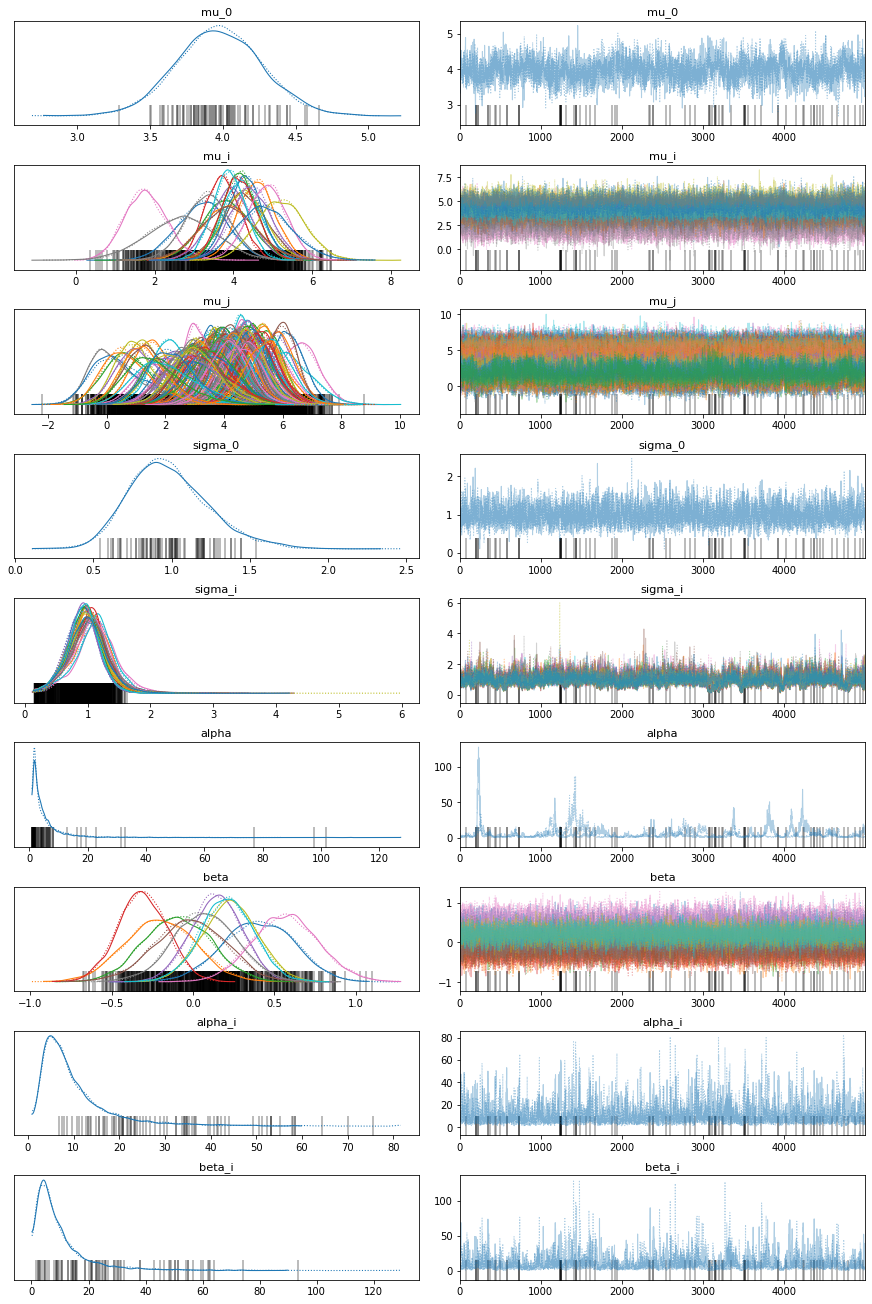

In [9]:
az.plot_trace(trace, var_names=['mu_0', 'mu_i', 'mu_j', 'sigma_0', 'sigma_i', 'alpha', 'beta', 'alpha_i', 'beta_i']);

In [10]:
pm.save_trace(trace, directory='output/trace/total_production', overwrite=True)

'output/trace/total_production'

#### _WAIC_

In [11]:
with model:
    idata = az.from_pymc3(trace, dims={'X':['foo'], 'y':['foo']})

idata.sample_stats['log_likelihood'] = idata.log_likelihood.y
az.waic(idata)

0, dim: foo, 143 =? 0
0, dim: foo, 143 =? 0


Computed from 10000 by 143 log-likelihood matrix

          Estimate       SE
elpd_waic  -705.09    19.48
p_waic      101.12        -

There has been a warning during the calculation. Please check the results.

# Summary

In [12]:
summary_coef = np.quantile(trace.beta, axis=0, q=[0.5, 0.05, 0.25, 0.75, 0.95])
summary_coef = pd.DataFrame(np.transpose(summary_coef))
summary_coef.index = X.columns[:-1]
summary_coef.columns = ['median', 'lower90', 'lower50', 'upper50', 'upper90']
summary_coef['rhat'] = az.rhat(trace).beta
summary_coef = summary_coef.drop(index=x_nuisance.columns)
summary_coef

,median,lower90,lower50,upper50,upper90,rhat
mean_educ,0.404542,0.039184,0.252473,0.558419,0.755031,1.000171
sat_model_est_wealth,-0.201077,-0.549736,-0.345100,-0.051423,0.152211,1.000138
gender_equality,-0.096093,-0.427016,-0.235241,0.044422,0.243819,1.000313
language_diversity,-0.312019,-0.560213,-0.413705,-0.208502,-0.060235,1.000148
cultural_hegemony,0.144839,-0.115109,0.039975,0.250522,0.399276,0.999990
working_percent_un,-0.017098,-0.384393,-0.164056,0.132799,0.337918,1.000300
mean_voice_account,0.567671,0.232656,0.430105,0.707084,0.912050,1.000236


In [13]:
summary_coef.to_csv('output/coef/coef_total_production.csv', index=True)

#### _Plot_

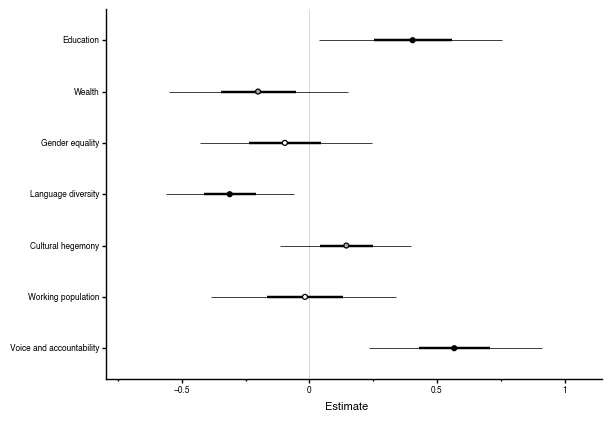

<ggplot: (324505193)>

In [14]:
summary_coef['var_name'] = cov_name
summary_coef = summary_coef[::-1]
summary_coef['var_name'] = pd.Categorical(summary_coef['var_name'], categories=summary_coef['var_name'])

# point color
foo = zip(summary_coef.lower90 * summary_coef.upper90, summary_coef.lower50 * summary_coef.upper50)
col = ['#000000' if x1 > 0 else '#aaaaaa' if x2 > 0 else '#ffffff' for (x1, x2) in foo]

# axis range
min_val = summary_coef.lower90.min()
max_val = summary_coef.upper90.max()
min_range = min_val - (max_val - min_val) * 0.1
max_range = max_val + (max_val - min_val) * 0.1

p = ggplot(aes(x='var_name', y='median'), data=summary_coef) + \
    geom_hline(yintercept=0, colour='#cccccc', size=0.3) + \
    geom_errorbar(aes(ymin='lower90', ymax='upper90', size=1, width=0)) + \
    geom_errorbar(aes(ymin='lower50', ymax='upper50', size=2, width=0)) + \
    scale_size_continuous(range=[0.3,1]) + \
    geom_point(size=1.5, fill=col) + \
    scale_y_continuous(limits=[min_range, max_range]) + \
    labs(x='', y='Estimate') + \
    coord_flip() + \
    theme_classic() + \
    theme(axis_text=element_text(size=6, colour='black', family='Helvetica'),
        axis_title=element_text(size=8, colour='black', family='Helvetica'),
        axis_line=element_line(color='black'),
        axis_ticks=element_line(color='black'),
        legend_position='none')
p

In [15]:
ggsave(p, 'plots/coef/total_production.pdf', width=1.5, height=2.5)

#### _Nuisance_

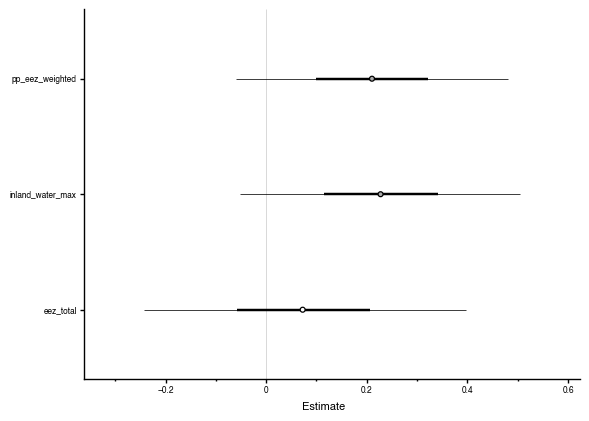

<ggplot: (324670901)>

In [16]:
summary_coef = np.quantile(trace.beta, axis=0, q=[0.5, 0.05, 0.25, 0.75, 0.95])
summary_coef = pd.DataFrame(np.transpose(summary_coef))
summary_coef.index = X.columns[:-1]
summary_coef.columns = ['median', 'lower90', 'lower50', 'upper50', 'upper90']
summary_coef = summary_coef.loc[x_nuisance.columns]

# plot
summary_coef['var_name'] = summary_coef.index
summary_coef['var_name'] = pd.Categorical(summary_coef['var_name'], categories=summary_coef['var_name'])

# point color
foo = zip(summary_coef.lower90 * summary_coef.upper90, summary_coef.lower50 * summary_coef.upper50)
col = ['#000000' if x1 > 0 else '#aaaaaa' if x2 > 0 else '#ffffff' for (x1, x2) in foo]

# axis range

min_val = min(0, summary_coef.lower90.min())
max_val = max(0, summary_coef.upper90.max())
min_range = min_val - (max_val - min_val) * 0.1
max_range = max_val + (max_val - min_val) * 0.1

p = ggplot(aes(x='var_name', y='median'), data=summary_coef) + \
    geom_hline(yintercept=0, colour='#cccccc', size=0.3) + \
    geom_errorbar(aes(ymin='lower90', ymax='upper90', size=1, width=0)) + \
    geom_errorbar(aes(ymin='lower50', ymax='upper50', size=2, width=0)) + \
    scale_size_continuous(range=[0.3,1]) + \
    geom_point(size=1.5, fill=col) + \
    scale_y_continuous(limits=[min_range, max_range]) + \
    labs(x='', y='Estimate') + \
    coord_flip() + \
    theme_classic() + \
    theme(axis_text=element_text(size=6, colour='black', family='Helvetica'),
        axis_title=element_text(size=8, colour='black', family='Helvetica'),
        axis_line=element_line(color='black'),
        axis_ticks=element_line(color='black'),
        legend_position='none')
p

In [17]:
ggsave(p, 'plots/nuisance/total_production.pdf', width=1.5, height=2.5)

# Deviation analysis

In [18]:
# estimates for regional mu and sigma
mu_i = np.quantile(trace.mu_i, axis=0, q=0.5)
sigma_i = np.quantile(trace.sigma_i, axis=0, q=0.5)

data = pd.DataFrame()
data['region_index'] = region_index
data['region'] = [region[x] for x in data.region_index]
data['country'] = df.loc[y_scaled.index, 'country_name_en'].values
data['iso3'] = df.loc[y_scaled.index, 'iso3c'].values
data['mu_j'] = np.quantile(trace.mu_j, axis=0, q=0.5)
data['mu_i'] = [mu_i[x] for x in data.region_index]
data['sigma_i'] = [sigma_i[x] for x in data.region_index]
data['sd'] = (data.mu_j - data.mu_i)/data.sigma_i
data['region_intercept'] = np.exp(data.mu_i) / scale_factor
data['nation_intercept'] = np.exp(data.mu_j) / scale_factor
data.head()

,region_index,region,country,iso3,mu_j,mu_i,sigma_i,sd,region_intercept,nation_intercept
0,1,Western Asia,United Arab Emirates,ARE,5.064678,4.590500,1.067600,0.444152,8629.908353,13865.601344
1,10,Southern Europe,Albania,ALB,3.828306,4.280120,0.917129,-0.492639,6327.174629,4027.073043
2,8,Middle Africa,Angola,AGO,5.068281,4.270456,0.979178,0.814792,6266.317912,13915.660109
3,9,South America,Argentina,ARG,5.046432,4.210179,1.116605,0.748925,5899.762972,13614.907843
4,15,Australia and New Zealand,Australia,AUS,2.608672,3.870262,1.038080,-1.215311,4199.626903,1189.348764


In [19]:
data.to_csv('output/sd/sd_total_production.csv', index=False)

#### _Plot deviations_

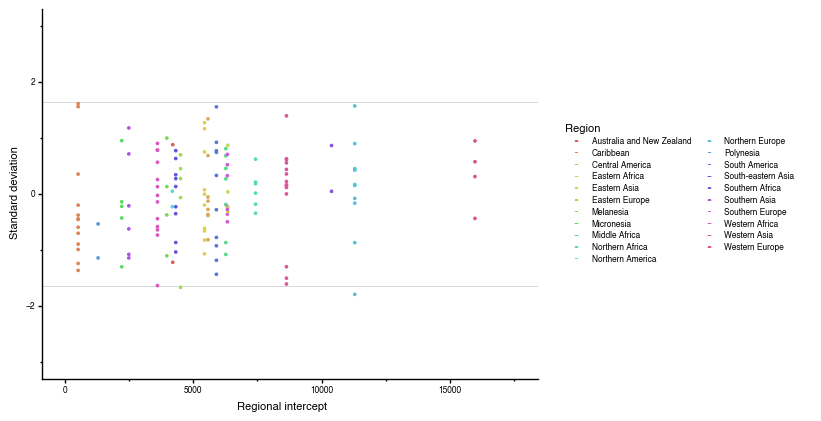

<ggplot: (329778029)>

In [20]:
p = ggplot(aes(x='region_intercept', y='sd'), data=data) + \
    geom_hline(yintercept=[-1.645, 1.645], color='#cccccc', size=0.3) + \
    geom_point(aes(color='region'), size=0.5) + \
    lims(x=[0,data.region_intercept.max()*1.1], y=[-3,3]) + \
    labs(x='Regional intercept', y='Standard deviation', color='Region') + \
    guides(color=guide_legend(ncol=2, keyheight=1)) + \
    theme_classic() + \
    theme(axis_text=element_text(size=6, colour='black', family='Helvetica'),
        axis_title=element_text(size=8, colour='black', family='Helvetica'),
        axis_line=element_line(color='black'),
        axis_ticks=element_line(color='black'),
        legend_title=element_text(size=8, colour='black', family='Helvetica'),
        legend_text=element_text(size=6, colour='black', family='Helvetica'))
p

In [21]:
ggsave(p, 'plots/sd/total_production.pdf', width=4, height=2.5)

#### _Plot a map_

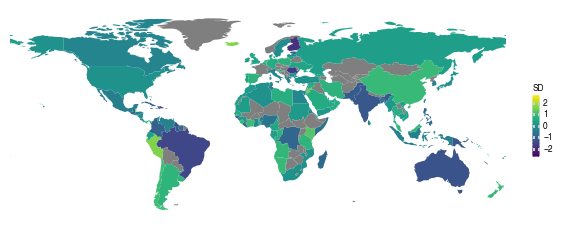

<ggplot: (329808269)>

In [22]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world = world.merge(data, how='left', left_on='iso_a3', right_on='iso3')
world.drop(world[world.iso_a3=='ATA'].index, inplace=True)

p = ggplot() + \
    geom_map(aes(fill='sd'), world, stroke=0, size=0) + \
    coord_equal() + \
    scale_x_continuous(limits=[-180, 180], expand=[0,0]) + \
    scale_y_continuous(limits=[-70, 90], expand=[0,0]) + \
    scale_fill_continuous(name='SD', limits=[-2.5, 2.5]) + \
    guides(fill=guide_colourbar(barwidth=3, barheight=6)) + \
    theme(plot_title=element_text(hjust=0, face=2, size=8, colour='black', family='Helvetica'),
        legend_title=element_text(size=6, colour='black', family='Helvetica'),
        legend_text=element_text(size=6, colour='black', family='Helvetica'),
        panel_grid_major=element_blank(),
        panel_grid_minor=element_blank(),
        axis_ticks=element_blank(),
        axis_text=element_blank(),
        axis_title=element_blank(),
        panel_background=element_rect(color='none', fill='none'))
p

In [23]:
ggsave(p, 'plots/map/total_production.pdf', width=4, height=2.5)